In [1]:
%cd C:\Users\debie\Documents\anaconda_space

C:\Users\debie\Documents\anaconda_space


# Predicting House Sale Prices

In [2]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv('AmesHousing.tsv', delimiter="\t")

def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    cols = list(df.columns)
    cols.remove('SalePrice')
    
    lr = LinearRegression()
    lr.fit(train[cols], train['SalePrice'])
    test_predictions = lr.predict(test[cols])
    test_mse = mean_squared_error(test_predictions, test['SalePrice'])
    rmse = np.sqrt(test_mse)
    return rmse

Handle missing values:

    All columns:
        Drop any with 5% or more missing values for now.
    Text columns:
        Drop any with 1 or more missing values for now.
    Numerical columns:
        For columns with missing values, fill in with the most common value in that column


In [4]:
miss_val = data.isnull().sum()
#there are 2930 row and 5% of 2930 = 146,5, we round it up to 147

more_5 = miss_val[miss_val > 2930 * 0.05] 

data = data.drop(more_5.index, axis = 1)

In [5]:
text_cols = data.select_dtypes(include=['object']).columns
text_count = data[text_cols].isnull().sum()
text_miss = text_count[text_count > 0]
data = data.drop(text_miss.index, axis = 1)

In [6]:
num_col = data.select_dtypes(include=['integer', 'float']).columns
d = data[num_col].isnull().sum()
fix_num = d[d>0]
fix_num

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [7]:
replacement_values_dict = data[fix_num.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [8]:
data = data.fillna(replacement_values_dict)

In [9]:
data.isnull().sum().value_counts()

0    64
dtype: int64

Creation of new feature

In [10]:
years_sold = data['Yr Sold'] - data['Year Built']

years_sold[years_sold < 0]

2180   -1
dtype: int64

In [11]:
years_remod = data['Yr Sold'] - data['Year Remod/Add']

years_remod[years_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [12]:
## Create new columns
data['Years Before Sale'] = years_sold
data['Years Since Remod'] = years_remod

## Drop rows with negative values for both of these new features
data = data.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
data = data.drop(["Year Built", "Year Remod/Add"], axis = 1)

We drop columns that are not useful and that leak data about the final sale.

In [13]:
data = data.drop(['PID','Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis = 1)

We now put all of that in the function transform_features:

In [14]:
def transform_features(df):
    miss_val = df.isnull().sum()
    more_5 = miss_val[miss_val > len(df) * 0.05] 
    df = df.drop(more_5.index, axis = 1)
    
    text_cols = df.select_dtypes(include=['object']).columns
    text_count = df[text_cols].isnull().sum()
    text_miss = text_count[text_count > 0]
    df = df.drop(text_miss.index, axis = 1)
    
    num_col = df.select_dtypes(include=['integer', 'float']).columns
    d = df[num_col].isnull().sum()
    fix_num = d[d>0]
    replacement_values_dict = df[fix_num.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    df = df.drop(['PID','Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis = 1)
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    cols = list(df.columns)
    cols.remove('SalePrice')
    
    lr = LinearRegression()
    lr.fit(train[cols], train['SalePrice'])
    test_predictions = lr.predict(test[cols])
    test_mse = mean_squared_error(test_predictions, test['SalePrice'])
    rmse = np.sqrt(test_mse)
    return rmse

In [15]:
data = pd.read_csv('AmesHousing.tsv', delimiter="\t")
transformed_data = transform_features(data)
selected_data = select_features(transformed_data)
rmse = train_and_test(selected_data)

rmse

55275.367312413066

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

In [16]:
import seaborn as sns
num_data = transformed_data.select_dtypes(include=['integer', 'float'])
corr_data = num_data.corr()
corr_data.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
MS SubClass,1.000000,-0.204638,0.040285,-0.067498,0.005502,-0.058276,-0.070936,-0.129873,-0.219990,-0.250497,0.304430,0.025743,0.071166,0.014516,-0.002027,0.134997,0.176359,-0.019531,0.257685,0.033684,-0.049386,-0.045453,-0.102769,-0.016283,-0.013309,-0.022963,-0.037988,-0.050696,-0.003451,-0.024356,-0.085128,-0.037655,-0.044886
Lot Area,-0.204638,1.000000,0.090426,-0.033487,0.114982,0.180192,0.084454,0.020899,0.241353,0.321311,0.030381,0.001105,0.273741,0.122329,0.022168,0.123632,0.032169,0.138303,-0.019809,0.208241,0.254772,0.176283,0.207487,0.152849,0.089202,0.023004,0.016619,0.056135,0.094421,0.038013,0.267520,-0.020882,-0.019848
Overall Qual,0.040285,0.090426,1.000000,-0.093907,0.418972,0.278274,-0.040551,0.268760,0.545792,0.474888,0.240300,-0.048585,0.567902,0.167279,-0.044949,0.520942,0.266939,0.064220,-0.159729,0.376199,0.391604,0.598485,0.561303,0.253120,0.290553,-0.139907,0.018537,0.042412,0.030638,-0.027685,0.801206,-0.596358,-0.570231
Overall Cond,-0.067498,-0.033487,-0.093907,1.000000,-0.132071,-0.050143,0.040846,-0.136758,-0.174840,-0.157746,0.006674,0.009123,-0.114930,-0.043252,0.084988,-0.213914,-0.087566,-0.006257,-0.086507,-0.088903,-0.031147,-0.181083,-0.153249,0.021046,-0.067152,0.071287,0.043804,0.043915,-0.016822,0.047066,-0.101540,0.369267,-0.046373
Mas Vnr Area,0.005502,0.114982,0.418972,-0.132071,1.000000,0.284305,-0.014139,0.087535,0.378545,0.376205,0.119674,-0.057375,0.387355,0.137158,0.008756,0.252318,0.186587,0.083399,-0.050531,0.267328,0.267449,0.354753,0.365786,0.158743,0.123395,-0.109775,0.014689,0.068366,0.005143,-0.022884,0.506983,-0.306163,-0.190821


<AxesSubplot:>

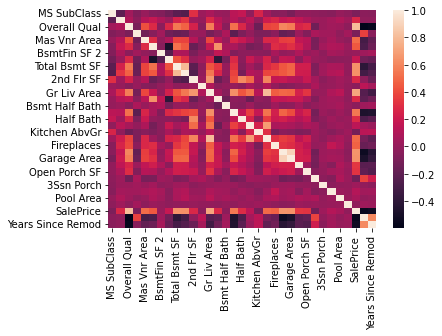

In [17]:
sns.heatmap(corr_data)

In [18]:
sale_corr = corr_data['SalePrice'].abs().sort_values(ascending = False)
sale_corr

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

Which columns in the data frame should be converted to the categorical data type ?

In [27]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?

In [30]:
transform_cat = []
for col in nominal_features:
    if col in transformed_data:
        transform_cat.append(col)
        

## How many unique values in each categorical column?
uniqueness_counts = transformed_data[transform_cat].apply(lambda col: len(col.value_counts())).sort_values()
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transformed_data = transformed_data.drop(drop_nonuniq_cols, axis=1)

In [32]:
## Select just the remaining text columns and convert to categorical
text_cols = transformed_data.select_dtypes(include=['object'])
for col in text_cols:
    transformed_data[col] = transformed_data[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transformed_data = pd.concat([
    transformed_data, 
    pd.get_dummies(transformed_data.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

In [35]:
def transform_features(df):
    miss_val = df.isnull().sum()
    more_5 = miss_val[miss_val > len(df) * 0.05] 
    df = df.drop(more_5.index, axis = 1)
    
    text_cols = df.select_dtypes(include=['object']).columns
    text_count = df[text_cols].isnull().sum()
    text_miss = text_count[text_count > 0]
    df = df.drop(text_miss.index, axis = 1)
    
    num_col = df.select_dtypes(include=['integer', 'float']).columns
    d = df[num_col].isnull().sum()
    fix_num = d[d>0]
    replacement_values_dict = df[fix_num.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    df = df.drop(['PID','Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis = 1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    num_col = df.select_dtypes(include=['integer', 'float'])
    abs_corr_coeffs = num_col.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    transform_cat = []
    for col in nominal_features:
        if col in df:
            transform_cat.append(col)
    uniqueness_counts = df[transform_cat].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    return df
    
def train_and_test(df, k=0):
    numeric = df.select_dtypes(include=['integer', 'float'])
    features = numeric.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        train = df[0:1460]
        test = df[1460:]
        lr.fit(train[features], train['SalePrice'])
        test_predictions = lr.predict(test[cols])
        test_mse = mean_squared_error(test_predictions, test['SalePrice'])
        rmse = np.sqrt(test_mse)
        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        fold_one = shuffled_df[1460:]
        fold_two = shuffled_df[:1460]
        
        lr.fit(fold_one[features], fold_one['SalePrice'])
        one_prediction = lr.predict(fold_two[features])
        
        mse_one = mean_squared_error(one_prediction, fold_two['SalePrice'])
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        two_prediction = lr.predict(fold_one[features])
        
        mse_two = mean_squared_error(two_prediction, fold_one['SalePrice'])
        rmse_two = np.sqrt(mse_two)
    
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse


In [36]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[26509.749379569028, 26077.94871402075, 35475.248565789116, 27857.855260464425]


28980.200479960826